In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import re
import warnings
from scipy.sparse import spdiags
from scipy import signal
from scipy.signal import butter
import scipy

%matplotlib inline

# Try importing ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except ImportError as e:
    widgets = None
    print("ipywidgets is not available in this environment. Interactive features will be disabled.")

In [15]:
# FILL THIS IN! This is the path to your preprocessed dataset folder.
preprocessed_dataset_path = '/hdd/data/PURE/PURE_SizeW128_SizeH128_ClipLength160_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/'

all_files = os.listdir(preprocessed_dataset_path)

input_files = [
    f for f in all_files
    if re.match(r"\d+_input\d+\.npz", f)
]

label_files = []
for input_file in input_files:
    label_file = input_file.replace("input", "label").replace(".npz", ".npy")
    if label_file in all_files:
        label_files.append(label_file)

if len(input_files) == 0 or len(label_files) == 0:
    print("Error: No valid input or label files found in the directory.")
else:
    print(f"{len(input_files)} input files and {len(label_files)} label files detected.")


750 input files and 750 label files detected.


In [ ]:
import numpy as np

# 파일 경로 지정
npz_path = "/hdd/data/PURE/PURE_SizeW128_SizeH128_ClipLength160_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/806_input9.npz"  # 예: '/hdd/data/PURE/.../1001_input0.npz'

# 파일 로드
data = np.load(npz_path)

# 내부 key 목록 출력
print("Keys in npz file:", data.files)

# 각 key에 대해 shape 및 dtype 출력
for key in data.files:
    arr = data[key]
    print(f"Key: {key}, Shape: {arr.shape}, Dtype: {arr.dtype}")


Keys in npz file: ['face', 'background']
Key: face, Shape: (160, 128, 128, 3), Dtype: float32
Key: background, Shape: (160, 128, 128, 3), Dtype: float32


In [ ]:
import numpy as np

# 파일 경로 지정
npz_path = "/hdd/data/PURE/PURE_SizeW128_SizeH128_ClipLength160_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/806_input9.npz"  # 예: '/hdd/data/PURE/.../1001_input0.npz'

# 파일 로드
data = np.load(npz_path)

# 내부 key 목록 출력
print("Keys in npz file:", data.files)

# 각 key에 대해 shape 및 dtype 출력
for key in data.files:
    arr = data[key]
    print(f"Key: {key}, Shape: {arr.shape}, Dtype: {arr.dtype}")


Keys in npz file: ['face', 'background']
Key: face, Shape: (160, 128, 128, 3), Dtype: float32
Key: background, Shape: (160, 128, 128, 3), Dtype: float32


In [ ]:
import numpy as np

# 파일 경로 지정
npz_path = "/hdd/data/PURE/PURE_SizeW128_SizeH128_ClipLength160_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/806_input9.npz"  # 예: '/hdd/data/PURE/.../1001_input0.npz'

# 파일 로드
data = np.load(npz_path)

# 내부 key 목록 출력
print("Keys in npz file:", data.files)

# 각 key에 대해 shape 및 dtype 출력
for key in data.files:
    arr = data[key]
    print(f"Key: {key}, Shape: {arr.shape}, Dtype: {arr.dtype}")


Keys in npz file: ['face', 'background']
Key: face, Shape: (160, 128, 128, 3), Dtype: float32
Key: background, Shape: (160, 128, 128, 3), Dtype: float32


In [ ]:
import numpy as np

# 파일 경로 지정
npz_path = "/hdd/data/PURE/PURE_SizeW128_SizeH128_ClipLength160_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/806_input9.npz"  # 예: '/hdd/data/PURE/.../1001_input0.npz'

# 파일 로드
data = np.load(npz_path)

# 내부 key 목록 출력
print("Keys in npz file:", data.files)

# 각 key에 대해 shape 및 dtype 출력
for key in data.files:
    arr = data[key]
    print(f"Key: {key}, Shape: {arr.shape}, Dtype: {arr.dtype}")


Keys in npz file: ['face', 'background']
Key: face, Shape: (160, 128, 128, 3), Dtype: float32
Key: background, Shape: (160, 128, 128, 3), Dtype: float32


In [ ]:
import numpy as np

# 파일 경로 지정
npz_path = "/hdd/data/PURE/PURE_SizeW128_SizeH128_ClipLength160_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/806_input9.npz"  # 예: '/hdd/data/PURE/.../1001_input0.npz'

# 파일 로드
data = np.load(npz_path)

# 내부 key 목록 출력
print("Keys in npz file:", data.files)

# 각 key에 대해 shape 및 dtype 출력
for key in data.files:
    arr = data[key]
    print(f"Key: {key}, Shape: {arr.shape}, Dtype: {arr.dtype}")


Keys in npz file: ['face', 'background']
Key: face, Shape: (160, 128, 128, 3), Dtype: float32
Key: background, Shape: (160, 128, 128, 3), Dtype: float32


In [16]:
import os
import re

# 데이터 경로
preprocessed_dataset_path = '/hdd/data/PURE/PURE_SizeW128_SizeH128_ClipLength160_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/'

all_files = os.listdir(preprocessed_dataset_path)

# input과 label 파일을 (session, index) 기준으로 매핑
inputs = {}
labels = {}

for f in all_files:
    m_input = re.match(r'(\d+)_input(\d+)\.npz', f)
    m_label = re.match(r'(\d+)_label(\d+)\.npy', f)
    if m_input:
        inputs[(m_input.group(1), m_input.group(2))] = f
    elif m_label:
        labels[(m_label.group(1), m_label.group(2))] = f

# 매칭되는 key만 추출
matched_keys = set(inputs.keys()) & set(labels.keys())
input_files = [inputs[k] for k in matched_keys]
label_files = [labels[k] for k in matched_keys]

# 결과 출력
if not input_files or not label_files:
    print("Error: No matching input-label file pairs found.")
else:
    print(f"{len(input_files)} matched input-label pairs found.")


750 matched input-label pairs found.


Dropdown(description='Chunk:', index=356, layout=Layout(width='800px'), options=('1001_input0.npz', '1001_inpu…

IntSlider(value=0, description='Frame:', layout=Layout(width='800px'), max=159)

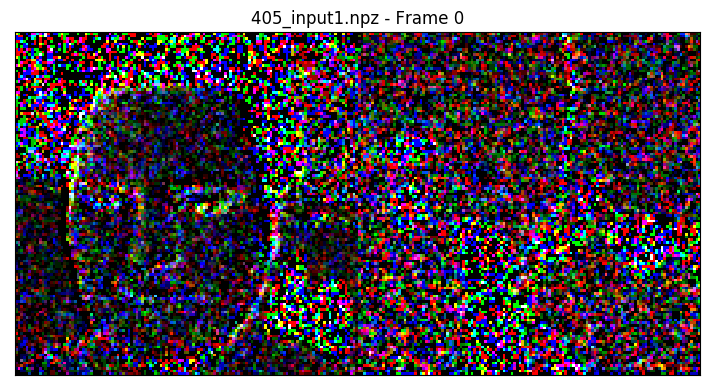

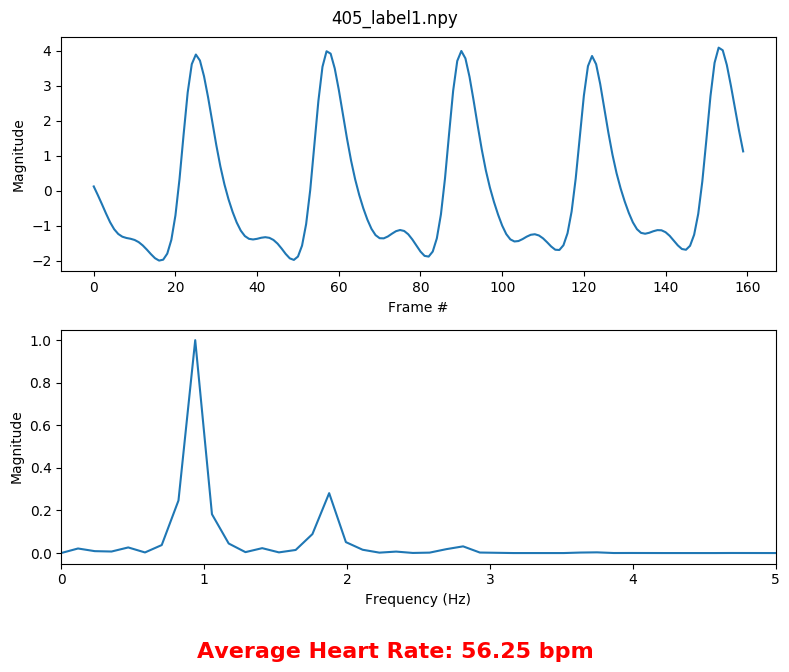

In [32]:
# Create the visualizer instance
visualizer = Visualizer(preprocessed_dataset_path, input_files, label_files)

# Create the label figure
visualizer.create_label_figure()